/Users/cyhuang/research/flux_limiter/src/utils/utils.py:20: RuntimeWarning: divide by zero encountered in divide
  r = (u - ul) / (ur - u)
/Users/cyhuang/research/flux_limiter/src/utils/utils.py:20: RuntimeWarning: invalid value encountered in divide
  r = (u - ul) / (ur - u)


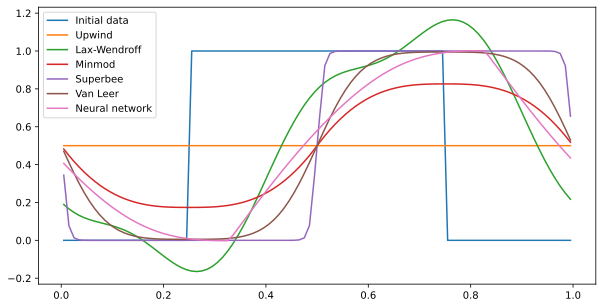

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

from models.model import FluxLimiter
from utils import fvm_solver, utils

device = 'cpu'

# Model
model = FluxLimiter(1,1,20,5)
model.load_state_dict(torch.load("../model.pt"))
model = model.to(device)

def neural_flux_limiter(r):
    model.eval()
    with torch.no_grad():
        phi = model(torch.Tensor(r).view(-1, 1).to(device))
    return phi.numpy().squeeze()

x0, u0 = utils.sin_wave(N=100)
x0, u0 = utils.square_wave(N=100)
# x0, u0 = utils.linear_spike(N=100)
# x0, u0 = utils.step(N=100)

flux_limiters = {
    "Upwind": utils.FOU,
    "Lax-Wendroff": utils.LaxWendroff,
    "Minmod": utils.minmod,
    "Superbee": utils.superbee,
    "Van Leer": utils.vanLeer,
    "Neural network": neural_flux_limiter,
}

fig, ax = plt.subplots()
ax.plot(x0, u0, label='Initial data', clip_on=False)
for (name, flux_limiter) in flux_limiters.items():
    u, _ = fvm_solver.solve_linear_advection_1D(u0=u0, T=100.25, a=1., dx=x0[1]-x0[0], CFL=0.5, flux_limiter=flux_limiter)
    ax.plot(x0, u, label=name, clip_on=False)
ax.legend()
fig.set_size_inches(10,5)
plt.show()

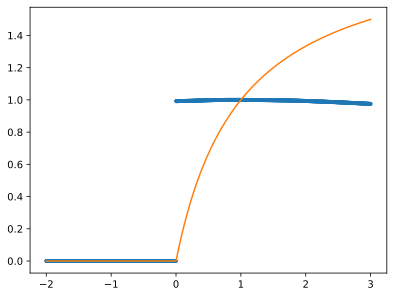

In [32]:
model.eval()
r_min = -2
r_max = 3
n_eval = 1000
r_eval = np.linspace(r_min, r_max, n_eval)
with torch.no_grad():
    preds = model(torch.Tensor(r_eval).view(-1,1))
fig, ax = plt.subplots()
ax.plot(r_eval, preds.cpu(), '.')
ax.plot(r_eval, utils.vanLeer(r_eval))
fig.savefig('learned_limiter_linear_case')